# Goal
WEB team has deployed the font menu on three pilot wikis: Polish Wikipedia, Spanish Wikipedia, and Dutch Wikipedia on May 6,2024.

We would like to learn how users so far have been using the new text size beta feature by answering a set of questions about the feature. This analysis will help us identify the next steps for the feature and confirm the deployment plan.

Answer the following questions:
- What percentage of logged-out users have changed their text?
- What percentage of logged-in users have changed their text?
- What were they most likely to change it towards?
- Of all clicks to the text section of the new menu, what percentage is for each text option?
- Were there any other interesting observations around the usage of the text menu?
- How frequently is the menu collapsed?



[Instrumentation ticket](https://phabricator.wikimedia.org/T350417)   | [QA ticket](https://phabricator.wikimedia.org/T350709)   
Analysis ticket:    
Pilot wiki deployment: [T364483](https://phabricator.wikimedia.org/T364483)

Previous analysis ticket: 
Beta feature deployement: [T359418](https://phabricator.wikimedia.org/T359418)   

__Jennifer Wang, Staff Data Scientist, Wikimedia Foundation__   
Analysis date: May 20, 2024


## Instrumentation Note


__Appearance menu on sidebar__    
<img src="Pictures/Appearance_menu_sidebar.png" width="800" height="600" align="center" style="border: 5px solid LightSteelBlue" />    
__Appearance menu in a dropdown menu__    
<img src="Pictures/Appearance_menu_dropdown.png" width="400" height="300" align="center" style="border: 5px solid LightSteelBlue" />    

Appearance menu can be located on the sidebar or in the dropdown menu.    
Click events and font values are captured in `event.desktopwebuiactionstracking` schema. 
`event.font` field captures the initial font value when the event is triggered.`event.name` field captures the font option that users click on.   
For logged-in users, the default font size is `Small`.  
For logged-out users, the default font size is `Standard`. 
[T362147](https://phabricator.wikimedia.org/T362147)

__Vector-2022, font size and font value mapping table__ 
|font size| font value in schema| event name of click on it|
|---|---|-----|
|Small| 0|skin-client-pref-vector-feature-custom-font-size-value-0|
|Standard|1|skin-client-pref-vector-feature-custom-font-size-value-1| 
|Large|2|skin-client-pref-vector-feature-custom-font-size-value-2|

The click on `move to sidebar` is captured as `event.name=pinnable-header.vector-appearance.pin and event.action=click`  
The click on `hide` is captured as `event.name=pinnable-header.vector-appearance.unpin and event.action=click`  
The clicks on the readability icon is caputured as `event.name=ui.dropdown-vector-appearance-dropdown and event.action=click`   

In [1]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
library(tidyverse); 
library(lubridate); 
library(scales);
library(magrittr); 
library(dplyr);
})

In [2]:
library(jsonlite)


Attaching package: ‘jsonlite’


The following object is masked from ‘package:purrr’:

    flatten




In [3]:
Sys.setenv(RETICULATE_PYTHON = "/home/jiawang/.conda/envs/2024-03-12T22.43.58_jiawang/bin/python")

In [4]:

library(reticulate)

In [5]:
library(wmfdata)

In [6]:
conda_env_data <- paste(
    system2(
        "conda",
        args = c("info", "-a", "--json"),
        stdout = TRUE),
    collapse = '') |>
    fromJSON()


In [7]:
use_condaenv(conda_env_data[['active_prefix']])

In [8]:

wmfdata <- import('wmfdata')

In [9]:
options(repr.plot.width = 15, repr.plot.height = 10)

# Analysis

## What percentage of logged-out users have changed their text? What percentage of logged-in users have changed their text?

In [10]:
query <- "
WITH t_c AS (
SELECT event.isAnon, 
COUNT(1) AS clicks,
COUNT(DISTINCT event.token) AS sessions
FROM event.desktopwebuiactionstracking
WHERE year=2024 and month=5 and day>6
AND wiki IN ('eswiki','nlwiki','plwiki')
AND event.action='click' 
AND event.skin='vector-2022'
AND event.name LIKE 'skin-client-pref-vector-feature-custom-font-size-value-%'
GROUP BY  event.isAnon
),
t_i AS (
SELECT event.isAnon, 
COUNT(1) AS inits,
COUNT(DISTINCT event.token) AS sessions
FROM event.desktopwebuiactionstracking
WHERE year=2024 and month=5 and day>6
AND wiki IN ('eswiki','nlwiki','plwiki')
AND event.action='init' 
AND event.skin='vector-2022'
GROUP BY  event.isAnon
)
SELECT t_c.isAnon, t_c.clicks, t_c.sessions AS click_sessions, t_i.inits, t_i.sessions AS init_sessions
FROM t_c JOIN t_i ON t_c.isAnon=t_i.isAnon
"

In [11]:
df <- wmfdata$spark$run(query)

In [12]:
df

isAnon clicks click_sessions inits    init_sessions
1 FALSE    6364   2096          1697577   131133     
2  TRUE  669092 211088         21372747 13362195

In [13]:
df_sessions <- df %>%
   mutate(
       click_rate = round(click_sessions/init_sessions,3 ),
       user_type=case_when(
          isAnon==TRUE ~ 'Anonymous users',
          isAnon==FALSE ~ 'Logged-in users'
           )
       )

In [14]:
df_sessions

isAnon clicks click_sessions inits    init_sessions click_rate
1 FALSE    6364   2096          1697577   131133      0.016     
2  TRUE  669092 211088         21372747 13362195      0.016     
  user_type      
1 Logged-in users
2 Anonymous users

### Findings

- Among logged-in users,1.6% of sessions have changed their text size.
- Among anonymous users, 1.6% of sessions have changed their text size.


## What were they most likely to change it towards?

### Method 2: check the last event.name to learn which font users opt for

In [15]:
query <- "
SELECT  distinct event.token AS session_id,
event.name, event.isAnon,
RANK() OVER(PARTITION BY event.token ORDER BY dt DESC) AS desc_order_num
FROM event.desktopwebuiactionstracking
WHERE year=2024 and month=5 and day>6
AND wiki IN ('eswiki','nlwiki','plwiki')
AND event.action='click' 
AND event.name LIKE 'skin-client-pref-vector-feature-custom-font-size-value-%' 
AND event.skin='vector-2022'
"

In [16]:
df <- wmfdata$spark$run(query)

In [17]:
df_font_events_all <- df

In [18]:
df %>% nrow()

[1] 657399

In [20]:
df %>% 
 filter(desc_order_num==1)  %>%
 nrow()

[1] 241783

In [22]:
df %>%
 filter(desc_order_num==1) %>%
 group_by(session_id) %>%
 summarize( cnt_last_event = n()) %>%
 filter(cnt_last_event>1) %>%
 nrow()

[1] 24985

In [23]:
df_exclude <- df %>%
 filter(desc_order_num==1) %>%
 group_by(session_id) %>%
 summarize( cnt_last_event = n()) %>%
 filter(cnt_last_event>1)

### Finding
24985 sessions have more than 1 event with the same last timestamp, also changed their font size at the last step.  

We will exclude these sessions from analysis since we cannot determine their most recent font size. 

In [24]:
# Exclude sessions which have more than 1 event with the same last timestamp, also changed their font size at the last step.   
df_font <- df %>%
   filter(desc_order_num==1) %>% 
   anti_join(df_exclude, join_by(session_id == session_id)) 

In [27]:
df_font <- df_font %>%
  mutate(
      event_name=case_when(
          name=='skin-client-pref-vector-feature-custom-font-size-value-0' ~ 'font-size-small',
          name=='skin-client-pref-vector-feature-custom-font-size-value-1' ~ 'font-size-standard',
          name=='skin-client-pref-vector-feature-custom-font-size-value-2' ~ 'font-size-large',
          TRUE ~ 'others'
          ),
       user_type=case_when(
          isAnon==TRUE ~ 'Anonymous users',
          isAnon==FALSE ~ 'Logged-in users'
           )
      )

In [30]:
df_font %>% 
  group_by(user_type, event_name) %>%
  summarize(cnt_sessions=n_distinct(session_id), .groups='drop') %>%
  group_by(user_type) %>%
  mutate(pct= cnt_sessions/sum(cnt_sessions))

user_type       event_name         cnt_sessions pct      
1 Anonymous users font-size-large    51133        0.2729976
2 Anonymous users font-size-small    80916        0.4320082
3 Anonymous users font-size-standard 55253        0.2949942
4 Logged-in users font-size-large      229        0.1231183
5 Logged-in users font-size-small      916        0.4924731
6 Logged-in users font-size-standard   715        0.3844086



### Conclusion 

For logged-in users:  
49.2% of sessions opt for small (font value 0) font size.  
38.4% of sessions opt for standard (font value 1) font size.  
12.3% of sessions opt for large (font value 2) font size.  


For anonymous users:  
43.2% of sessions opt for small (font value 0) font size.  
29.5% of sessions opt for standard (font value 1) font size.  
27.3% of sessions opt for large (font value 2) font size.  


## Question: Of all clicks to the text section of the new menu, what percentage is for each text option?

In [31]:
query <- "
select   event.skin,
    event.isAnon, 
event.name, 
COUNT(1) AS clicks,
COUNT(DISTINCT event.token) AS sessions,
COUNT(DISTINCT event.pageToken) AS pages
FROM event.desktopwebuiactionstracking
WHERE year=2024 and month=5 and day>6
AND wiki IN ('eswiki','nlwiki','plwiki')
AND event.action='click' 
AND event.name LIKE 'skin-client-pref-vector-feature-custom-font-size-value-%'
GROUP BY event.skin, event.isAnon, event.name
ORDER BY isAnon, name
LIMIT 100
"

In [32]:
df <- wmfdata$spark$run(query)

In [33]:
df

skin        isAnon name                                                    
1 vector-2022 FALSE  skin-client-pref-vector-feature-custom-font-size-value-0
2 vector-2022 FALSE  skin-client-pref-vector-feature-custom-font-size-value-1
3 vector-2022 FALSE  skin-client-pref-vector-feature-custom-font-size-value-2
4 vector-2022  TRUE  skin-client-pref-vector-feature-custom-font-size-value-0
5 vector-2022  TRUE  skin-client-pref-vector-feature-custom-font-size-value-1
6 vector-2022  TRUE  skin-client-pref-vector-feature-custom-font-size-value-2
  clicks sessions pages 
1   2203   1510     1673
2   2719   1763     1917
3   1472   1186     1275
4 250160 162476   163747
5 199415 112000   112788
6 222500 143826   144769

In [34]:
df_click <-df %>%
 select(isAnon,name, clicks)%>%
 group_by(isAnon) %>%
 mutate(
     click_pct = round(clicks/sum(clicks),3 )
     )

data by May 20

In [35]:
df_click

isAnon name                                                     clicks
1 FALSE  skin-client-pref-vector-feature-custom-font-size-value-0   2203
2 FALSE  skin-client-pref-vector-feature-custom-font-size-value-1   2719
3 FALSE  skin-client-pref-vector-feature-custom-font-size-value-2   1472
4  TRUE  skin-client-pref-vector-feature-custom-font-size-value-0 250160
5  TRUE  skin-client-pref-vector-feature-custom-font-size-value-1 199415
6  TRUE  skin-client-pref-vector-feature-custom-font-size-value-2 222500
  click_pct
1 0.345    
2 0.425    
3 0.230    
4 0.372    
5 0.297    
6 0.331

### Conclusions
For logged-in users:
Of all clicks to the text section of the new menu
- 34.5% of them are clicks for small font size
- 42.5% of them are clicks for standard font size
- 23.0% of them are clicks for large font size

For anonymous users:
Of all clicks to the text section of the new menu
- 37.2% of them are clicks for small font size
- 29.7% of them are clicks for standard font size
- 33.1% of them are clicks for large font size

### Daily trend

In [37]:
query <- "
SELECT  date_format(dt, 'yyyy-MM-dd') AS event_date, event.isAnon,
event.name,
COUNT(1) AS clicks,
COUNT(DISTINCT event.token) AS sessions,
COUNT(DISTINCT event.pageToken) AS pages
FROM event.desktopwebuiactionstracking
WHERE year=2024 and month>4
AND wiki IN ('eswiki','nlwiki','plwiki')
AND event.action='click' 
AND event.name LIKE 'skin-client-pref-vector-feature-custom-font-size-value-%' 
GROUP BY date_format(dt, 'yyyy-MM-dd') , event.isAnon, event.name
"

In [38]:
df <- wmfdata$spark$run(query)

In [39]:
df$event_date <- as.Date(df$event_date)

In [40]:
df <- df %>%
  mutate(
      event_name=case_when(
          name=='skin-client-pref-vector-feature-custom-font-size-value-0' ~ 'font-size-small',
          name=='skin-client-pref-vector-feature-custom-font-size-value-1' ~ 'font-size-standard',
          name=='skin-client-pref-vector-feature-custom-font-size-value-2' ~ 'font-size-large',
          TRUE ~ 'others'
          ),
       user_type=case_when(
          isAnon==TRUE ~ 'Anonymous users',
          isAnon==FALSE ~ 'Logged-in users'
           )
      )

In [42]:
options(repr.plot.width = 15, repr.plot.height = 8)

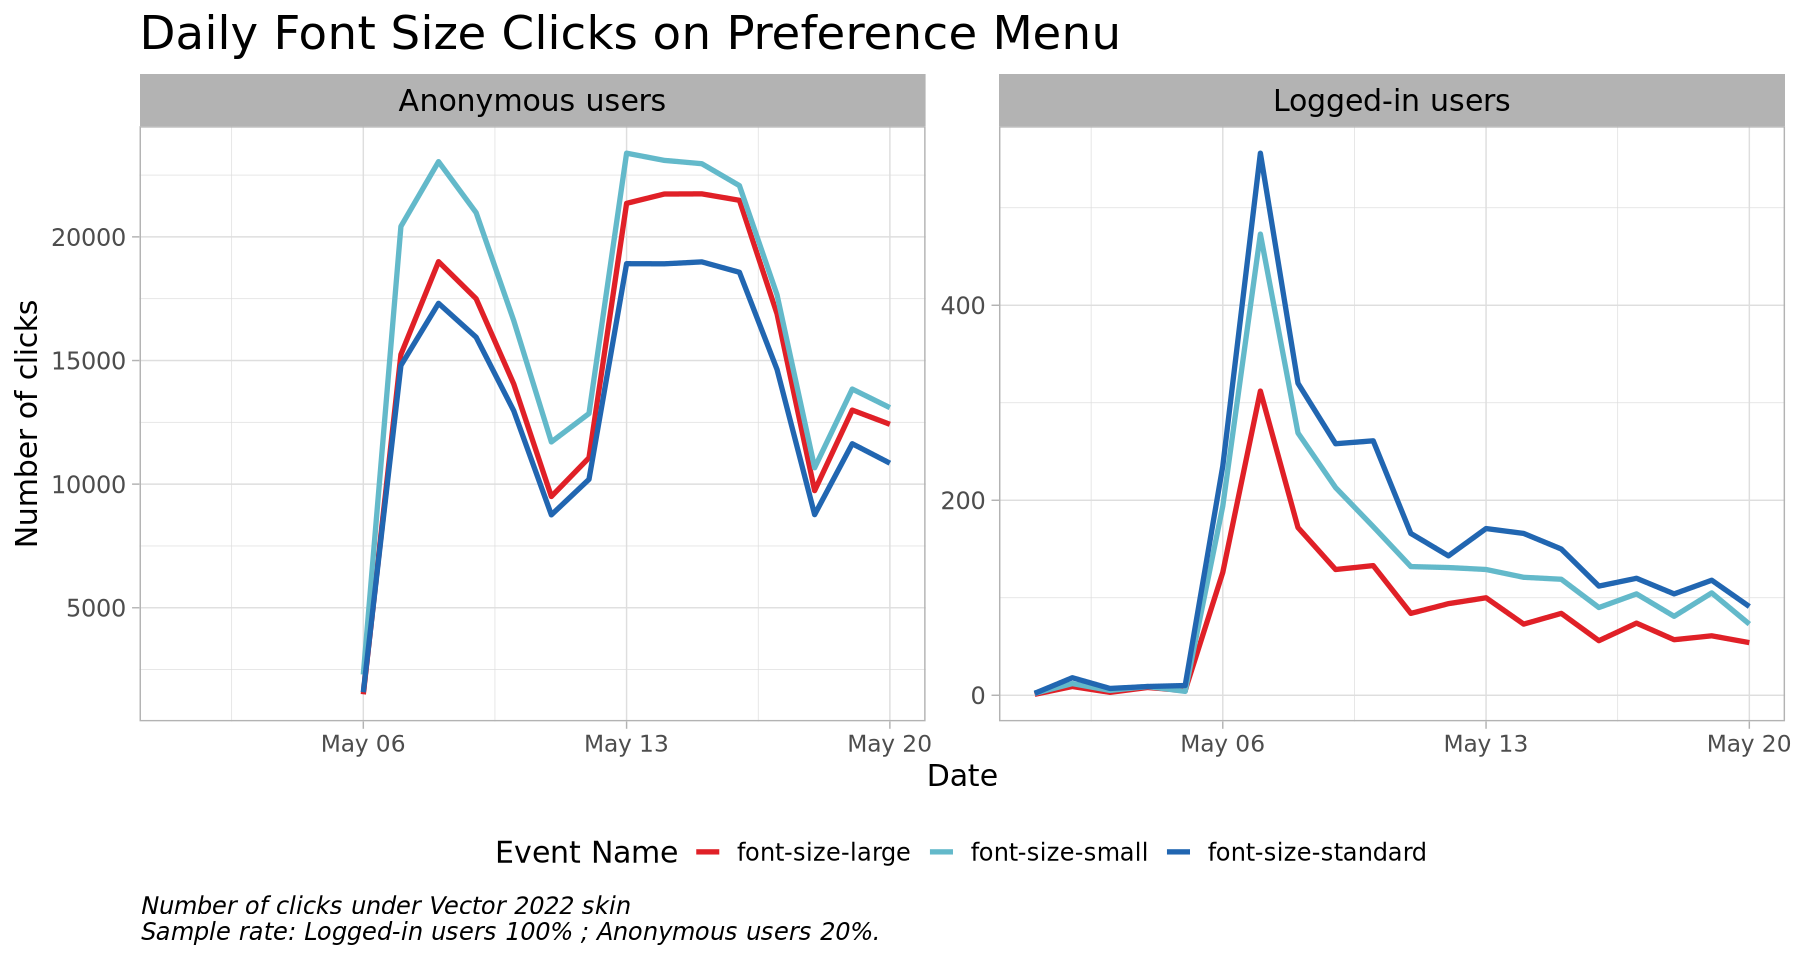

In [43]:
daily_g <- df  %>%
   ggplot(mapping=aes(x=event_date, y=clicks, color=event_name)) +
   geom_line( linewidth = 1.5) +
   facet_wrap(~user_type, scale = 'free_y') +
  scale_color_manual(values= c("#E02027", "#63B9CA", "#2166B1"), name = "Event Name")  +
  labs(title = 'Daily Font Size Clicks on Preference Menu',
     x = 'Date',
     y = 'Number of clicks',
     caption = "Number of clicks under Vector 2022 skin
Sample rate: Logged-in users 100% ; Anonymous users 20%.") +
theme_light(base_size=18) +
theme(legend.position='bottom', 
     plot.caption = element_text(hjust = 0, face= "italic"),
     strip.text = element_text(size = 18, colour='black'),
     axis.text.x = element_text( size = 14 ),
     plot.title = element_text(size=28))
daily_g

### Findings

The trend is consistent on a daily basis.  
For the logged-in users, there are more clicks to opt for the standard font size, followed by clicks for a small size. The clicks for the large font size are fewer.  
For the anonymous users, there are more clicks to opt for the small font size, followed by clicks for a large size. The clicks for the standard font size are fewer because the default font size is standard. 

## How frequently is the menu collapsed?

We'll measure how many times the user clicked the 'hide' button to collapse the appearance menu.

In [44]:
query <- "
select   
    event.isAnon, 
COUNT(1) AS clicks,
COUNT(DISTINCT event.token) AS sessions
FROM event.desktopwebuiactionstracking
WHERE year=2024 and month=5 and day>6
AND wiki IN ('eswiki','nlwiki','plwiki')
AND event.skin='vector-2022'
AND event.action='click' 
AND event.name='pinnable-header.vector-appearance.unpin'
GROUP BY event.isAnon, event.name
ORDER BY isAnon
LIMIT 100
"

In [45]:
df <- wmfdata$spark$run(query)

In [46]:
df

isAnon clicks sessions
1 FALSE   2204   2081   
2  TRUE  80723  79800

## Curiosity questions

### How many sessions clicked font menu at least once between 2024-05-07 and 2024-05-20 ?

In [47]:
query <- "
select   event.skin,
    event.isAnon, 
COUNT(1) AS clicks,
COUNT(DISTINCT event.token) AS sessions,
COUNT(DISTINCT event.pageToken) AS pages
FROM event.desktopwebuiactionstracking
WHERE year=2024 and month=5 and day>6
AND event.action='click' 
AND event.name LIKE 'skin-client-pref-vector-feature-custom-font-size-value-%'
GROUP BY event.skin, event.isAnon
"

In [48]:
df <- wmfdata$spark$run(query)

In [50]:
df

skin        isAnon clicks sessions pages 
1 vector-2022 FALSE    9226   3015     3556
2 vector-2022  TRUE  681620 215147   217704